In [1]:
import gc
import logging
import os
import shutil
import time

In [2]:
import keras
import tensorflow as tf
from keras import layers, Sequential
from keras import ops
from keras.src.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.src.optimizers import Adam, AdamW, RMSprop, SGD
from keras.src.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from pandas import DataFrame

2024-10-16 21:47:12.052370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 21:47:12.734589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
IMAGES_PATH = "resources/Images"
CROPPED_IMAGES_PATH = "resources/Cropped_Images2"
MODELS_PATH = "models/custom_model_hyperoptimization"
MODEL_SAVE_PATH = f"{MODELS_PATH}/custom_model.keras"
CHECKPOINT_SAVE_PATH = f"{MODELS_PATH}/checkpoint.keras"
RESULTS_PATH = "results/custom_model_hyperoptimization"

To optimize GPU memory consumption

In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
data_augmentation_layers = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

2024-10-16 21:47:13.774156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 21:47:13.821002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 21:47:13.823804: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
def remove_last_generated_models_and_results():
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)
    shutil.rmtree(RESULTS_PATH, ignore_errors=True)
    os.makedirs(RESULTS_PATH)

In [7]:
def get_dataset(path, image_size, batch_size, validation_split=0.0, data_type=None):
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=image_size,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )

In [8]:
def get_optimizer(optimizer, learning_rate):
    match optimizer:
        case "adam":
            return Adam(learning_rate=learning_rate)
        case "adamw":
            return AdamW(learning_rate=learning_rate)
        case "rmsprop":
            return RMSprop(learning_rate=learning_rate)
        case "sgd":
            return SGD(learning_rate=learning_rate)
        case "sgdn":
            return SGD(learning_rate=learning_rate, nesterov=True)
        case _:
            raise ValueError(f"Unknown optimizer:{optimizer}.")

In [9]:
def create_simplified_vit(input_shape, labels_number, patch_size=4, projection_dim=64, num_heads=2,
                          transformer_layers=2, mlp_head_units=256, optimizer="adamw", learning_rate=0.001):
    inputs = keras.Input(shape=input_shape)
    inputs = data_augmentation_layers(inputs)

    # Create patches
    patches = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patch_dims = patches.shape[1] * patches.shape[2]
    patches = layers.Reshape((patch_dims, projection_dim))(patches)

    # Add positional embeddings
    positions = tf.range(start=0, limit=patch_dims, delta=1)
    pos_embedding = layers.Embedding(input_dim=patch_dims, output_dim=projection_dim)(positions)
    patches += pos_embedding

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(patches)
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(projection_dim * 2, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim)(x3)
        x3 = layers.Dropout(0.1)(x3)
        # Skip connection 2
        patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(patches)
    representation = layers.GlobalAveragePooling1D()(representation)

    # MLP, classify outputs
    features = layers.Dense(mlp_head_units, activation="gelu")(representation)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(labels_number, activation='softmax')(features)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=get_optimizer(optimizer, learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            # keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    return model

In [10]:
def display_results(results, hyperparameter_name):
    results_df = DataFrame(results)
    display_results_plot(results_df, hyperparameter_name, ["fitting_time"], "fitting_time")
    display_results_plot(results_df, hyperparameter_name, ["test_accuracy", "val_accuracy"], "accuracies",
                         ascending=False)
    display_results_plot(results_df, hyperparameter_name, ["test_loss", "val_loss"], "losses")

In [11]:
def display_results_plot(results, hyperparameter_name, metrics, metrics_name, ascending=True):
    results.sort_values(metrics[0], ascending=ascending, inplace=True)
    performance_plot = (results[metrics + ["hyperparameters_name"]]
                        .plot(kind="bar", x="hyperparameters_name", figsize=(15, 8), rot=0,
                              title=f"Results sorted by {metrics_name}"))
    
    performance_plot.title.set_size(20)
    performance_plot.set_xticks(range(0, len(results)))
    plt.xticks(rotation=90)
    performance_plot.set(xlabel=None)
    # performance_plot.get_figure().savefig(f"{RESULTS_PATH}/{hyperparameter_name}_{metrics_name}_plot.png",
                                          # bbox_inches='tight')
    plt.show()
    plt.close()

In [12]:
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
    checkpoint = ModelCheckpoint(CHECKPOINT_SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
    
    return [checkpoint, es, reduce_lr]

In [13]:
def get_results_of_model(model, dataset_train, dataset_val, dataset_test, parameters, epoch=1000, batch_size=4):
    fitting_start_time = time.time()
    model.fit(dataset_train,
              validation_data=dataset_val,
              batch_size=batch_size,
              # epochs=2,
              epochs=epoch,
              callbacks=get_callbacks(),
              verbose=1)
    fitting_time = time.time() - fitting_start_time
    
    model.load_weights(CHECKPOINT_SAVE_PATH)
    
    val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
    print(f"\nValidation Accuracy:{val_accuracy}.")
    
    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
    print(f"\nTest Accuracy:{test_accuracy}.\n")
    
    return {
        "hyperparameters_name": hyperparameters["name"],
        "fitting_time": fitting_time,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
        **parameters
    }

In [14]:
def get_best_parameter(sorted_results, parameter_name):
    best_parameter = sorted_results[0][parameter_name]
    print(f"Best parameter:{parameter_name.replace("_", " ")} found:{best_parameter}.\n")
    return best_parameter

Starting custom models learning script.

Found 5195 files belonging to 30 classes.
Using 4156 files for training.
Found 5195 files belonging to 30 classes.
Using 1039 files for validation.
Found 5195 files belonging to 30 classes.

Testing now the parameters:{'patch_size': 4}.

Epoch 1/1000


I0000 00:00:1729090039.702206  191458 service.cc:145] XLA service 0x7944e8009770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729090039.702238  191458 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-10-16 21:47:19.815240: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 21:47:20.286059: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1729090043.391211  191713 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729090043.651618  191719 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 72 bytes spill stores, 72 bytes spill loads

I

   5/1039 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.0000e+00 - loss: 3.8576 

I0000 00:00:1729090051.209881  191458 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0325 - loss: 3.5026

I0000 00:00:1729090086.124568  192095 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 60 bytes spill stores, 60 bytes spill loads

I0000 00:00:1729090086.186949  192091 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 476 bytes spill stores, 460 bytes spill loads

I0000 00:00:1729090086.189221  192094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 220 bytes spill stores, 220 bytes spill loads

I0000 00:00:1729090090.942882  192145 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729090091.189489  192140 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729090091.652291  1


Epoch 1: val_loss improved from inf to 3.33941, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 58s 41ms/step - accuracy: 0.0325 - loss: 3.5025 - val_accuracy: 0.0635 - val_loss: 3.3394 - learning_rate: 0.0010
Epoch 2/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0693 - loss: 3.3140
Epoch 2: val_loss improved from 3.33941 to 3.25973, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.0693 - loss: 3.3140 - val_accuracy: 0.0616 - val_loss: 3.2597 - learning_rate: 0.0010
Epoch 3/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0689 - loss: 3.2720
Epoch 3: val_loss improved from 3.25973 to 3.23737, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.0689 - loss: 3.2720 - val_accuracy: 0.0847 - val_loss: 3.2374 - learning_rate: 0.0010
Epoch 4/1000
1039

I0000 00:00:1729091975.977660  201383 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 76 bytes spill stores, 76 bytes spill loads

I0000 00:00:1729091975.989831  201376 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1729091976.017583  201382 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1729091976.148186  201368 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_86', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1729091976.866989  201381 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729091977.322310  201368 

1035/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0400 - loss: 3.5274

I0000 00:00:1729091988.249590  201609 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1729091988.273442  201615 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729091988.354915  201618 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 268 bytes spill stores, 268 bytes spill loads

I0000 00:00:1729091988.463630  201610 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 528 bytes spill stores, 516 bytes spill loads

I0000 00:00:1729091990.156875  201671 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_18', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1729091990.577202  201656 


Epoch 1: val_loss improved from inf to 3.39921, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.0400 - loss: 3.5270 - val_accuracy: 0.0289 - val_loss: 3.3992 - learning_rate: 0.0010
Epoch 2/1000
1038/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0600 - loss: 3.3571
Epoch 2: val_loss improved from 3.39921 to 3.30721, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0600 - loss: 3.3570 - val_accuracy: 0.0722 - val_loss: 3.3072 - learning_rate: 0.0010
Epoch 3/1000
1030/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0676 - loss: 3.2944
Epoch 3: val_loss improved from 3.30721 to 3.25911, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0676 - loss: 3.2943 - val_accuracy: 0.0568 - val_loss: 3.2591 - learning_rate: 0.0010
Epoch 4/1000
1038/1039 ━

I0000 00:00:1729092463.689624  206939 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_86', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1729092463.978934  206943 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 120 bytes spill stores, 120 bytes spill loads

I0000 00:00:1729092463.978969  206944 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 120 bytes spill stores, 120 bytes spill loads

I0000 00:00:1729092464.396420  206934 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729092464.769716  206945 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 108 bytes spill stores, 108 bytes spill loads

I0000 00:00:1729092464.915616  206940 

1024/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0289 - loss: 3.5114

I0000 00:00:1729092474.939769  207171 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1729092474.980279  207179 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1729092475.060190  207180 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 476 bytes spill stores, 460 bytes spill loads

I0000 00:00:1729092476.620663  207217 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_18', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1729092477.283917  207212 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729092477.755591  207


Epoch 1: val_loss improved from inf to 3.42955, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.0290 - loss: 3.5107 - val_accuracy: 0.0356 - val_loss: 3.4296 - learning_rate: 0.0010
Epoch 2/1000
1032/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0594 - loss: 3.3802
Epoch 2: val_loss improved from 3.42955 to 3.30681, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0594 - loss: 3.3799 - val_accuracy: 0.0597 - val_loss: 3.3068 - learning_rate: 0.0010
Epoch 3/1000
1021/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0637 - loss: 3.2884
Epoch 3: val_loss did not improve from 3.30681
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0637 - loss: 3.2882 - val_accuracy: 0.0693 - val_loss: 3.3332 - learning_rate: 0.0010
Epoch 4/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0767 - loss: 3.2654
Epoch 4: v

I0000 00:00:1729092778.181979  211942 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729092778.320634  211934 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 104 bytes spill stores, 104 bytes spill loads

I0000 00:00:1729092778.575455  211933 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_86', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1729092778.727355  211932 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_86', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1729092778.806661  211947 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 120 bytes spill stores, 120 bytes spill loads

I0000 00:00:1729092779.098233  2119

1035/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0358 - loss: 3.5168

I0000 00:00:1729092787.707921  212192 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1729092788.042164  212189 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 512 bytes spill stores, 492 bytes spill loads

I0000 00:00:1729092789.531328  212246 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_18', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1729092789.549355  212249 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_18', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1729092789.621941  212248 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_18', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1729092789.911782  212247 


Epoch 1: val_loss improved from inf to 3.42959, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.0358 - loss: 3.5165 - val_accuracy: 0.0308 - val_loss: 3.4296 - learning_rate: 0.0010
Epoch 2/1000
1026/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0430 - loss: 3.4251
Epoch 2: val_loss improved from 3.42959 to 3.33299, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0431 - loss: 3.4248 - val_accuracy: 0.0472 - val_loss: 3.3330 - learning_rate: 0.0010
Epoch 3/1000
1021/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0667 - loss: 3.3271
Epoch 3: val_loss improved from 3.33299 to 3.29491, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0666 - loss: 3.3269 - val_accuracy: 0.0481 - val_loss: 3.2949 - learning_rate: 0.0010
Epoch 4/1000
1020/1039 ━

I0000 00:00:1729093089.161207  217186 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1729093089.262537  217192 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1729093090.410663  217181 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1729093090.478876  217194 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 48 bytes spill stores, 48 bytes spill loads



1021/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0406 - loss: 3.5194

I0000 00:00:1729093099.374009  217420 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1729093099.416598  217407 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 48 bytes spill stores, 48 bytes spill loads




Epoch 1: val_loss improved from inf to 3.42469, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.0406 - loss: 3.5185 - val_accuracy: 0.0395 - val_loss: 3.4247 - learning_rate: 0.0010
Epoch 2/1000
1021/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0429 - loss: 3.4059
Epoch 2: val_loss improved from 3.42469 to 3.34896, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0430 - loss: 3.4055 - val_accuracy: 0.0558 - val_loss: 3.3490 - learning_rate: 0.0010
Epoch 3/1000
1029/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0616 - loss: 3.3207
Epoch 3: val_loss improved from 3.34896 to 3.28144, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0617 - loss: 3.3205 - val_accuracy: 0.0597 - val_loss: 3.2814 - learning_rate: 0.0010
Epoch 4/1000
1039/1039 ━

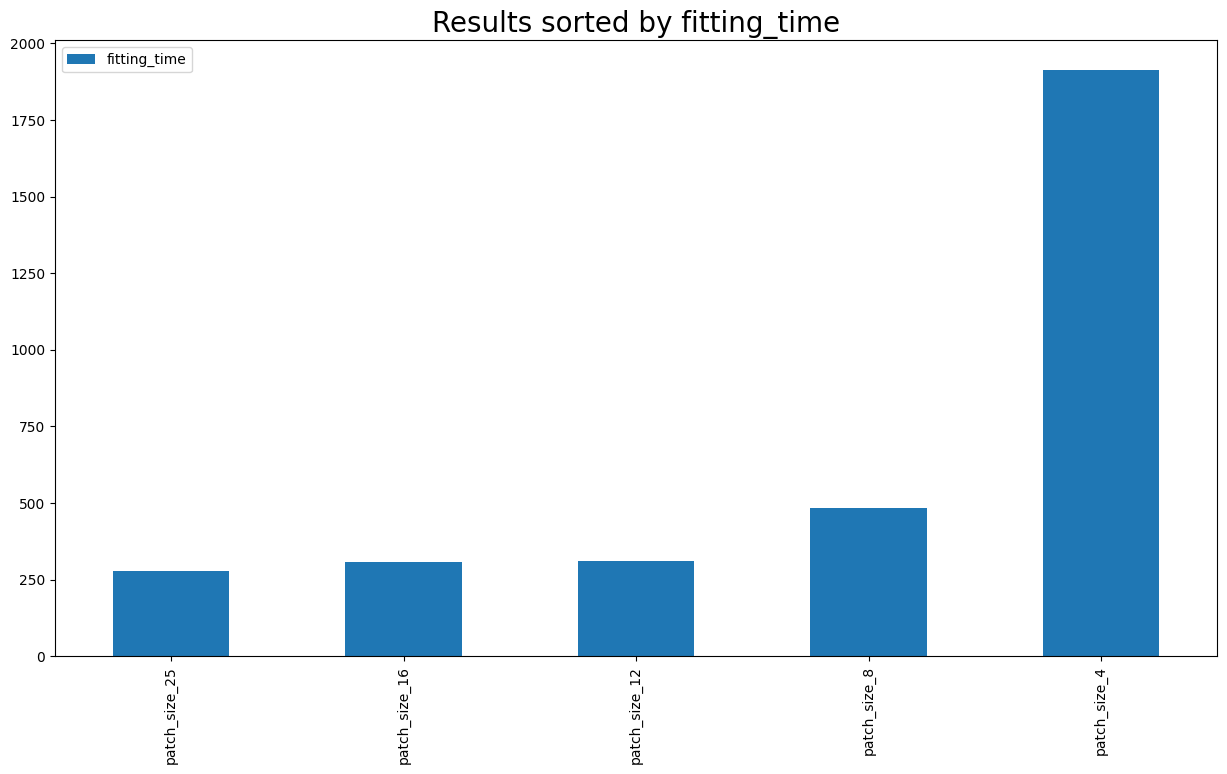

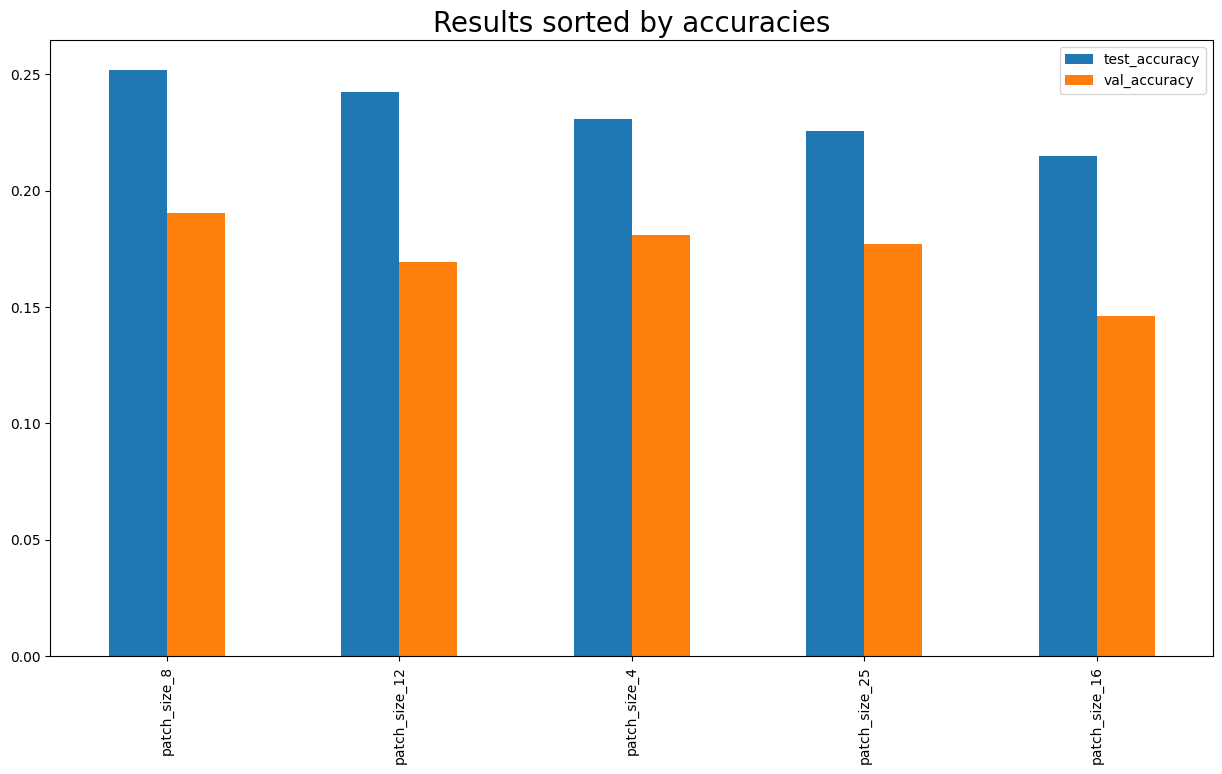

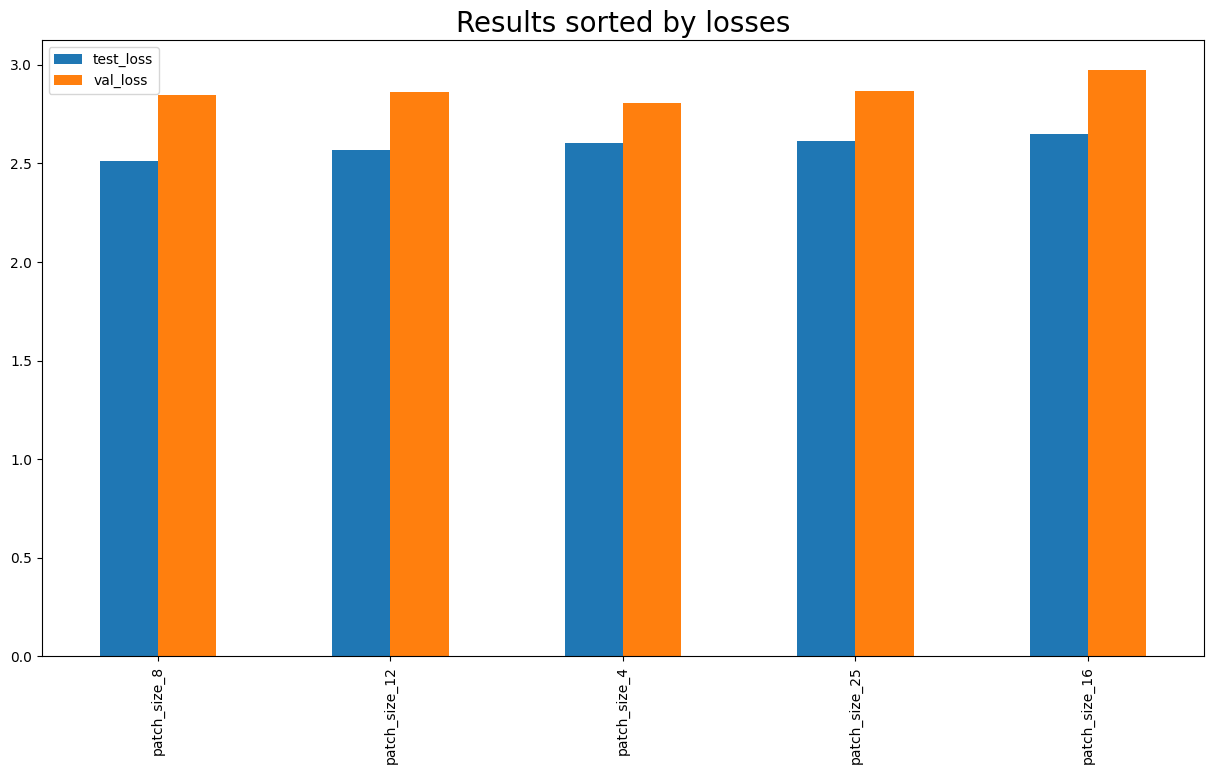

Testing now the parameters:{'num_heads': 1}.

Epoch 1/1000


I0000 00:00:1729093370.206715  222166 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30', 60 bytes spill stores, 60 bytes spill loads

I0000 00:00:1729093370.807709  222160 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_24', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1729093370.885087  222158 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30', 16 bytes spill stores, 20 bytes spill loads

I0000 00:00:1729093370.892177  222157 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1729093370.892556  222162 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_24', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1729093370.949329  222164 as

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0383 - loss: 3.4869

I0000 00:00:1729093400.030128  222393 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 144 bytes spill stores, 80 bytes spill loads

I0000 00:00:1729093400.056498  222391 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1729093400.084779  222395 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1729093400.101420  222390 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from inf to 3.33588, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.0383 - loss: 3.4868 - val_accuracy: 0.0510 - val_loss: 3.3359 - learning_rate: 0.0010
Epoch 2/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0645 - loss: 3.3180
Epoch 2: val_loss improved from 3.33588 to 3.27357, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.0645 - loss: 3.3179 - val_accuracy: 0.0760 - val_loss: 3.2736 - learning_rate: 0.0010
Epoch 3/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0750 - loss: 3.2631
Epoch 3: val_loss improved from 3.27357 to 3.21620, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.0750 - loss: 3.2631 - val_accuracy: 0.0741 - val_loss: 3.2162 - learning_rate: 0.0010
Epoch 4/1000
1039

I0000 00:00:1729097849.290248  244766 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 80 bytes spill stores, 80 bytes spill loads

I0000 00:00:1729097849.693842  244770 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729097850.076949  244771 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 72 bytes spill stores, 72 bytes spill loads



1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0454 - loss: 3.4919

I0000 00:00:1729097918.178634  245088 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 156 bytes spill stores, 156 bytes spill loads

I0000 00:00:1729097918.188961  245094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 60 bytes spill stores, 60 bytes spill loads

I0000 00:00:1729097918.225392  245092 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 3.31747, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.0454 - loss: 3.4919 - val_accuracy: 0.0722 - val_loss: 3.3175 - learning_rate: 0.0010
Epoch 2/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0675 - loss: 3.3142
Epoch 2: val_loss improved from 3.31747 to 3.27320, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - accuracy: 0.0675 - loss: 3.3142 - val_accuracy: 0.0654 - val_loss: 3.2732 - learning_rate: 0.0010
Epoch 3/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0793 - loss: 3.2735
Epoch 3: val_loss improved from 3.27320 to 3.23970, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - accuracy: 0.0793 - loss: 3.2735 - val_accuracy: 0.0731 - val_loss: 3.2397 - learning_rate: 0.0010
Epoch 4/1000
1039

I0000 00:00:1729102068.249863  263312 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729102068.762834  263325 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729102068.815648  263315 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 144 bytes spill stores, 144 bytes spill loads

I0000 00:00:1729102068.881699  263323 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729102069.069371  263321 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729102070.014558  263321 

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0389 - loss: 3.5005

I0000 00:00:1729102166.574399  263810 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729102166.958559  263815 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 252 bytes spill stores, 252 bytes spill loads

I0000 00:00:1729102167.020562  263803 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 296 bytes spill stores, 304 bytes spill loads

I0000 00:00:1729102176.597283  263869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1729102176.766932  263875 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 128 bytes spill stores, 128 bytes spill loads




Epoch 1: val_loss improved from inf to 3.32698, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 117s 99ms/step - accuracy: 0.0389 - loss: 3.5004 - val_accuracy: 0.0549 - val_loss: 3.3270 - learning_rate: 0.0010
Epoch 2/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0662 - loss: 3.3212
Epoch 2: val_loss improved from 3.32698 to 3.27987, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 98s 95ms/step - accuracy: 0.0662 - loss: 3.3212 - val_accuracy: 0.0635 - val_loss: 3.2799 - learning_rate: 0.0010
Epoch 3/1000
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0766 - loss: 3.2691
Epoch 3: val_loss improved from 3.27987 to 3.21827, saving model to models/custom_model_hyperoptimization/checkpoint.keras
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 98s 95ms/step - accuracy: 0.0766 - loss: 3.2691 - val_accuracy: 0.0683 - val_loss: 3.2183 - learning_rate: 0.0010
Epoch 4/1000
103

I0000 00:00:1729112419.258022  305153 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_92', 68 bytes spill stores, 68 bytes spill loads

I0000 00:00:1729112419.543722  305145 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729112419.812594  305140 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 76 bytes spill stores, 76 bytes spill loads

2024-10-17 04:00:35.087056: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.19GiB (rounded to 4502257920)requested by op 
2024-10-17 04:00:35.091023: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-10-17 04:00:35.091061: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 5699

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_191354/4149496506.py", line 54, in <module>

  File "/tmp/ipykernel_191354/1641078150.py", line 3, in get_results_of_model

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 4502257792 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    4.14MiB
              constant allocation:         0B
        maybe_live_out allocation:    1.08MiB
     preallocated temp allocation:    4.19GiB
  preallocated temp fragmentation:       380B (0.00%)
                 total allocation:    4.20GiB
              total fragmentation:    42.2KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 1.17GiB
		XLA Label: fusion
		Shape: f32[32,3136,3136]
		==========================

	Buffer 2:
		Size: 1.17GiB
		Operator: op_type="Transpose" op_name="functional_10_1/multi_head_attention_19_1/transpose_2" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="triton_gemm_dot.86.0"
		XLA Label: fusion
		Shape: f32[4,8,3136,3136]
		==========================

	Buffer 3:
		Size: 1.17GiB
		XLA Label: fusion
		Shape: f32[32,3136,3136]
		==========================

	Buffer 4:
		Size: 300.12MiB
		Operator: op_type="GreaterEqual" op_name="functional_10_1/multi_head_attention_18_1/dropout_45_1/stateless_dropout/GreaterEqual" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="input_concatenate_fusion.4"
		XLA Label: fusion
		Shape: pred[78675968,4]
		==========================

	Buffer 5:
		Size: 300.12MiB
		Operator: op_type="GreaterEqual" op_name="functional_10_1/multi_head_attention_19_1/dropout_47_1/stateless_dropout/GreaterEqual" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="input_concatenate_fusion.4"
		XLA Label: fusion
		Shape: pred[78675968,4]
		==========================

	Buffer 6:
		Size: 6.12MiB
		Operator: op_type="Mul" op_name="functional_10_1/dense_56_1/Gelu/mul_1" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="loop_multiply_fusion.2"
		XLA Label: fusion
		Shape: f32[12544,128]
		==========================

	Buffer 7:
		Size: 6.12MiB
		Operator: op_type="BatchMatMulV2" op_name="functional_10_1/dense_56_1/MatMul" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="triton_gemm_dot.4.0"
		XLA Label: fusion
		Shape: f32[12544,128]
		==========================

	Buffer 8:
		Size: 6.12MiB
		Operator: op_type="Mul" op_name="functional_10_1/dense_54_1/Gelu/mul_1" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="loop_multiply_fusion.2"
		XLA Label: fusion
		Shape: f32[12544,128]
		==========================

	Buffer 9:
		Size: 6.12MiB
		Operator: op_type="BatchMatMulV2" op_name="functional_10_1/dense_54_1/MatMul" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="triton_gemm_dot.4.0"
		XLA Label: fusion
		Shape: f32[12544,128]
		==========================

	Buffer 10:
		Size: 4.00MiB
		Operator: op_type="BatchMatMulV2" op_name="gradient_tape/functional_10_1/dense_57_1/MatMul/MatMul_1" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: s8[4194304]
		==========================

	Buffer 11:
		Size: 3.06MiB
		XLA Label: fusion
		Shape: f32[64,12544]
		==========================

	Buffer 12:
		Size: 3.06MiB
		Operator: op_type="Mean" op_name="functional_10_1/layer_normalization_47_1/moments/mean" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="input_add_reduce_fusion.4"
		XLA Label: fusion
		Shape: f32[4,64,3136]
		==========================

	Buffer 13:
		Size: 3.06MiB
		XLA Label: fusion
		Shape: f32[64,12544]
		==========================

	Buffer 14:
		Size: 3.06MiB
		Operator: op_type="Mean" op_name="functional_10_1/layer_normalization_46_1/moments/mean" source_file="/home/xavier/Desktop/formation/project_7/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177 deduplicated_name="input_add_reduce_fusion.4"
		XLA Label: fusion
		Shape: f32[4,64,3136]
		==========================

	Buffer 15:
		Size: 3.06MiB
		XLA Label: fusion
		Shape: f32[64,12544]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_5530240]

In [15]:
if __name__ == '__main__':
    print("Starting custom models learning script.\n")
    remove_last_generated_models_and_results()

    image_size = (224, 224)
    batch_size = 4
    labels_number = 30

    dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, validation_split=0.2,
                                data_type='training')
    dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, validation_split=0.2,
                              data_type='validation')
    dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, data_type=None)

    best_layers_parameters = {}

    # default_model = create_model(input_shape=image_size + (3,), labels_number=labels_number)
    # print(default_model.summary())

    # MODEL HYPEROPTIMIZATION
    results = []
    for hyperparameters in [
        {"name": "patch_size_4", "parameters": {"patch_size": 4}},
        {"name": "patch_size_8", "parameters": {"patch_size": 8}},
        {"name": "patch_size_12", "parameters": {"patch_size": 12}},
        {"name": "patch_size_16", "parameters": {"patch_size": 16}},
        {"name": "patch_size_25", "parameters": {"patch_size": 25}}
    ]:
        print(f"\nTesting now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_simplified_vit(input_shape=image_size + (3,), labels_number=labels_number,
                                      **hyperparameters["parameters"])

        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))


    sorted_results = sorted(results, key=lambda x: x["val_loss"])
    best_layers_parameters["patch_size"] = get_best_parameter(sorted_results, "patch_size")
    display_results(sorted_results, "patch_size")

    results = []
    for hyperparameters in [
        {"name": "num_heads_1", "parameters": {"num_heads": 1}},
        {"name": "num_heads_2", "parameters": {"num_heads": 2}},
        {"name": "num_heads_4", "parameters": {"num_heads": 4}},
        {"name": "num_heads_6", "parameters": {"num_heads": 6}},
        {"name": "num_heads_8", "parameters": {"num_heads": 8}}
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_simplified_vit(input_shape=image_size + (3,), labels_number=labels_number,
                                      patch_size=best_layers_parameters["patch_size"],
                                      **hyperparameters["parameters"])

        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))


    sorted_results = sorted(results, key=lambda x: x["val_loss"])
    best_layers_parameters["num_heads"] = get_best_parameter(sorted_results, "num_heads")
    display_results(sorted_results, "num_heads")

    results = []
    for hyperparameters in [
        {"name": "transformer_layers_1", "parameters": {"transformer_layers": 1}},
        {"name": "transformer_layers_2", "parameters": {"transformer_layers": 2}},
        {"name": "transformer_layers_3", "parameters": {"transformer_layers": 3}},
        {"name": "transformer_layers_4", "parameters": {"transformer_layers": 4}},
        {"name": "transformer_layers_5", "parameters": {"transformer_layers": 5}},
        {"name": "transformer_layers_6", "parameters": {"transformer_layers": 6}},
        {"name": "transformer_layers_8", "parameters": {"transformer_layers": 8}}
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_simplified_vit(input_shape=image_size + (3,), labels_number=labels_number,
                                      patch_size=best_layers_parameters["patch_size"],
                                      num_heads=best_layers_parameters["num_heads"],
                                      **hyperparameters["parameters"])

        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))


    sorted_results = sorted(results, key=lambda x: x["val_loss"])
    best_layers_parameters["transformer_layers"] = get_best_parameter(sorted_results, "transformer_layers")
    display_results(sorted_results, "transformer_layers")

    results = []
    for hyperparameters in [
        {"name": "mlp_head_units_64", "parameters": {"mlp_head_units": 64}},
        {"name": "mlp_head_units_128", "parameters": {"mlp_head_units": 128}},
        {"name": "mlp_head_units_256", "parameters": {"mlp_head_units": 256}},
        {"name": "mlp_head_units_512", "parameters": {"mlp_head_units": 512}},
        {"name": "mlp_head_units_1024", "parameters": {"mlp_head_units": 1024}}
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_simplified_vit(input_shape=image_size + (3,), labels_number=labels_number,
                                      patch_size=best_layers_parameters["patch_size"],
                                      num_heads=best_layers_parameters["num_heads"],
                                      transformer_layers=best_layers_parameters["transformer_layers"],
                                      **hyperparameters["parameters"])

        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))


    sorted_results = sorted(results, key=lambda x: x["val_loss"])
    best_layers_parameters["mlp_head_units"] = get_best_parameter(sorted_results, "mlp_head_units")
    display_results(sorted_results, "mlp_head_units")
    
    
    results = []
    for hyperparameters in [
        {"name": "projection_dim_16", "parameters": {"projection_dim": 16}},
        {"name": "projection_dim_32", "parameters": {"projection_dim": 32}},
        {"name": "projection_dim_64", "parameters": {"projection_dim": 64}},
        {"name": "projection_dim_128", "parameters": {"projection_dim": 128}},
        {"name": "projection_dim_256", "parameters": {"projection_dim": 256}}
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_simplified_vit(input_shape=image_size + (3,), labels_number=labels_number,
                                      patch_size=best_layers_parameters["patch_size"],
                                      num_heads=best_layers_parameters["num_heads"],
                                      transformer_layers=best_layers_parameters["transformer_layers"],
                                      mlp_head_units=best_layers_parameters["mlp_head_units"],
                                      **hyperparameters["parameters"])
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))


    sorted_results = sorted(results, key=lambda x: x["val_loss"])
    best_layers_parameters["projection_dim"] = get_best_parameter(sorted_results, "projection_dim")
    display_results(sorted_results, "projection_dim")


    # COMPILATION HYPEROPTIMIZATION
    results = []
    for hyperparameters in [
        {"name": "rmsprop_optimizer", "parameters": {"optimizer": "rmsprop"}},
        {"name": "adam_optimizer", "parameters": {"optimizer": "adam"}},
        {"name": "adamw_optimizer", "parameters": {"optimizer": "adamw"}},
        {"name": "sgd_optimizer", "parameters": {"optimizer": "sgd"}},
        {"name": "sgd_nesterov_optimizer", "parameters": {"optimizer": "sgdn"}},
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_simplified_vit(input_shape=image_size + (3,), labels_number=labels_number,
                                      patch_size=best_layers_parameters["patch_size"],
                                      projection_dim=best_layers_parameters["projection_dim"],
                                      num_heads=best_layers_parameters["num_heads"],
                                      transformer_layers=best_layers_parameters["transformer_layers"],
                                      mlp_head_units=best_layers_parameters["mlp_head_units"],
                                      **hyperparameters["parameters"])

        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))


    sorted_results = sorted(results, key=lambda x: x["val_loss"])
    best_layers_parameters["optimizer"] = get_best_parameter(sorted_results, "optimizer")
    display_results(sorted_results, "optimizer")


    # EXECUTION HYPEROPTIMIZATION
    # results = []
    # for hyperparameters in [
    #     {"name": "batch_size_4", "parameters": {"batch_size": 4}},
    #     {"name": "batch_size_8", "parameters": {"batch_size": 8}},
    #     {"name": "batch_size_16", "parameters": {"batch_size": 16}},
    #     {"name": "batch_size_32", "parameters": {"batch_size": 32}},
    # ]:
    #     print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
    # 
    #     model = create_simplified_vit(input_shape=image_size + (3,), labels_number=labels_number,
    #                                   patch_size=best_layers_parameters["patch_size"],
    #                                   projection_dim=best_layers_parameters["projection_dim"],
    #                                   num_heads=best_layers_parameters["num_heads"],
    #                                   transformer_layers=best_layers_parameters["transformer_layers"],
    #                                   mlp_head_units=best_layers_parameters["mlp_head_units"],
    #                                   optimizer=best_layers_parameters["optimizer"],
    #                                   learning_rate=best_layers_parameters["learning_rate"])
    # 
    #     new_batch_size = hyperparameters["parameters"]["batch_size"]
    #     dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, new_batch_size, validation_split=0.25,
    #                                 data_type='training')
    #     dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, new_batch_size, validation_split=0.25,
    #                               data_type='validation')
    #     dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, new_batch_size, data_type=None)
    # 
    #     results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
    #                                         hyperparameters["parameters"],
    #                                         epoch=best_layers_parameters["epoch"],
    #                                         batch_size=new_batch_size))


    # sorted_results = sorted(results, key=lambda x: x["val_loss"])
    # best_layers_parameters["batch_size"] = get_best_parameter(sorted_results, "batch_size")
    # display_results(sorted_results, "batch_size")

    print(f"Hyperoptimization now done. Best hyperparameters found:{best_layers_parameters}.\n")
    print("Custom models learning script finished.\n")